## CNN (Convolutional Neural Network)

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from helper_functions import accuracy_fn
from tqdm.auto import tqdm

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0+cu117
torchvision version: 0.15.1+cu117


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
train_data = FashionMNIST(
    root="data",
    download=True,
    train=True,
    transform=ToTensor()
)
test_data = FashionMNIST(
    root="data",
    download=True,
    train=False,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, 32, shuffle=True)
test_dataloader = DataLoader(test_data, 32, shuffle=True)

In [6]:
classes = train_data.classes

In [7]:
class CNNModel(nn.Module):
    def __init__(self, input, hidden, output, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.block1 = nn.Sequential(
            nn.Conv2d(input, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*7*7,
                      out_features=output)
        )
        
    def forward(self, x):
        return self.classifier(self.block2(self.block1(x)))


In [8]:
model = CNNModel(1, 10, len(classes)).to(device)

In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for (X, y) in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [11]:
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1} of {epochs}")
    train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
    test_step(model, train_dataloader, loss_fn, accuracy_fn, device)
    
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 of 3
Train loss: 0.68370 | Train accuracy: 74.98%
Test loss: 0.40038 | Test accuracy: 86.17%

Epoch 2 of 3
Train loss: 0.35889 | Train accuracy: 87.08%
Test loss: 0.32413 | Test accuracy: 88.43%

Epoch 3 of 3
Train loss: 0.32558 | Train accuracy: 88.27%
Test loss: 0.32146 | Test accuracy: 87.93%



In [12]:
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_results

{'model_name': 'CNNModel',
 'model_loss': 0.35636261105537415,
 'model_acc': 86.36182108626198}

In [14]:


y_preds = []
y_trues = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_data, desc="Making predictions"):
        y_logits = model(X.unsqueeze(0))

        y_pred = torch.softmax(y_logits, dim=1).squeeze().argmax(dim=0)     
        y_preds.append(y_pred)
        y_trues.append(y)

Making predictions:   0%|          | 0/10000 [00:00<?, ?it/s]

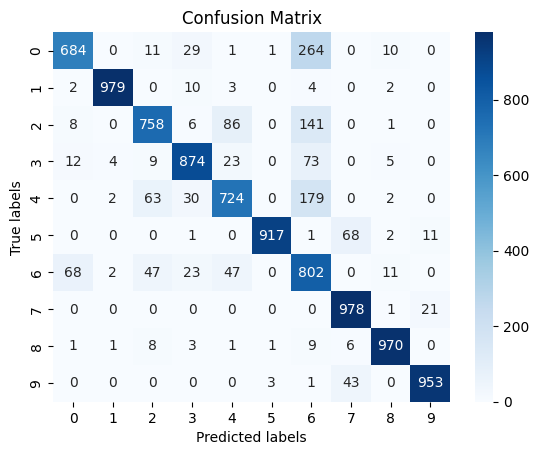

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_trues, y_pred=y_preds)
# Create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')


# Show plot
plt.show()